## **Conditional GAN with MNIST Dataset**

**Importing Libraries**

In [1]:
import tensorflow as tf
import tensorflow_datasets as tfds
import numpy as np
import matplotlib.pyplot as plt
import plotly.graph_objects as go
from IPython import display
from tqdm import tqdm
import glob
import imageio.v2 as imageio
import os
from google.colab import drive

**Parameters**

In [2]:
epochs=20
z_dim=64
batch_size=128
buffer_size=1024
n_classes=10
AUTOTUNE=tf.data.AUTOTUNE

**Load and Preprocess the Dataset**

In [3]:
train_dataset, info = tfds.load("mnist", split=tfds.Split.TRAIN, as_supervised=True, with_info=True)
info

tfds.core.DatasetInfo(
    name='mnist',
    full_name='mnist/3.0.1',
    description="""
    The MNIST database of handwritten digits.
    """,
    homepage='http://yann.lecun.com/exdb/mnist/',
    data_dir='/root/tensorflow_datasets/mnist/3.0.1',
    file_format=tfrecord,
    download_size=11.06 MiB,
    dataset_size=21.00 MiB,
    features=FeaturesDict({
        'image': Image(shape=(28, 28, 1), dtype=uint8),
        'label': ClassLabel(shape=(), dtype=int64, num_classes=10),
    }),
    supervised_keys=('image', 'label'),
    disable_shuffling=False,
    splits={
        'test': <SplitInfo num_examples=10000, num_shards=1>,
        'train': <SplitInfo num_examples=60000, num_shards=1>,
    },
    citation="""@article{lecun2010mnist,
      title={MNIST handwritten digit database},
      author={LeCun, Yann and Cortes, Corinna and Burges, CJ},
      journal={ATT Labs [Online]. Available: http://yann.lecun.com/exdb/mnist},
      volume={2},
      year={2010}
    }""",
)

In [4]:
def preprocessing(image, label):
  image = tf.cast(image, dtype=tf.float32)/127.5 -1
  label = tf.one_hot(label, n_classes)
  return image, label

In [5]:
train_dataset = (train_dataset
                 .map(preprocessing)
                 .shuffle(buffer_size, seed=123)
                 .batch(batch_size)
                 .prefetch(AUTOTUNE))

In [6]:
for im, la in train_dataset.take(1):
  print(im.shape, la.shape)

(128, 28, 28, 1) (128, 10)


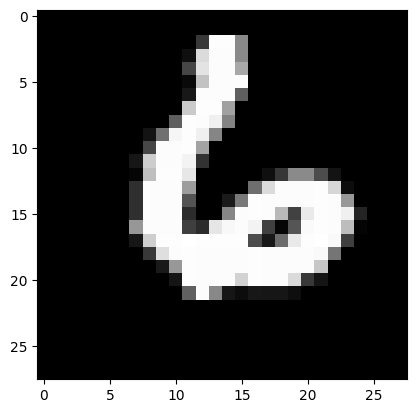

In [7]:
plt.imshow(im[0], cmap="gray");

In [8]:
la[0].numpy()

array([0., 0., 0., 0., 0., 0., 1., 0., 0., 0.], dtype=float32)

**Utilities**

In [ ]:
drive.mount("/content/drive/")

In [9]:
# Images directory
directory_images = "/content/drive/MyDrive/images"
directory_mnist = os.path.join(directory_images, "mnist_cond_gan")

os.makedirs(directory_mnist, exist_ok=True)

In [10]:
# Display functions

def make_grid(images, num_examples, nrow):
  images=tf.unstack(images[:num_examples], axis=0)
  images=tf.concat(images, axis=1)
  images=tf.split(images, nrow, axis=1)
  images=tf.concat(images, axis=0)

  return images

def show_and_save_images(real_images, fake_images, fake_images_example, epoch, num_examples=25, nrow=5):

  real_images = make_grid(real_images, num_examples, nrow)
  fake_images = make_grid(fake_images, num_examples, nrow)
  real_images = tf.cast((real_images+1) * 127.5, tf.uint8) # Denormalization
  fake_images = tf.cast((fake_images+1) * 127.5, tf.uint8)

  fig, ax = plt.subplots(1, 2, figsize=(nrow*2, nrow*2))
  ax[0].imshow(fake_images, cmap="gray")
  ax[0].axis("off")
  ax[0].set_title("Generated Images")

  ax[1].imshow(real_images, cmap="gray")
  ax[1].axis("off")
  ax[1].set_title("Real Images")

  plt.show()

  # Save fake images
  fake_images_example = make_grid(fake_images_example, num_examples, nrow)
  fake_images_example = tf.cast((fake_images_example+1) * 127.5, tf.uint8)
  plt.imshow(fake_images_example, cmap="gray")
  plt.axis("off")
  plt.savefig(os.path.join(directory_mnist, f"image{epoch:02d}.png"), transparent=True)
  plt.close()

**Building the Models**

In [11]:
tf.keras.backend.clear_session()

In [12]:
def model_generator(input_shape=(1, 1, z_dim+n_classes)):
  initializer = tf.keras.initializers.RandomNormal(0., 0.02, seed=123)

  input=tf.keras.Input(shape=input_shape)
  x=tf.keras.layers.Conv2DTranspose(256, (7,7), strides=1, padding="valid", kernel_initializer=initializer, use_bias=False)(input)
  x=tf.keras.layers.BatchNormalization()(x)
  x=tf.keras.layers.Dropout(0.5)(x)
  x=tf.keras.layers.ReLU()(x)

  x=tf.keras.layers.Conv2DTranspose(128, (4,4), strides=2, padding="same", kernel_initializer=initializer, use_bias=False)(x)
  x=tf.keras.layers.BatchNormalization()(x)
  x=tf.keras.layers.ReLU()(x)

  x=tf.keras.layers.Conv2DTranspose(1, (4,4), strides=2, padding="same", kernel_initializer=initializer, activation="tanh")(x)

  model=tf.keras.Model(inputs=input, outputs=x, name="generator")

  return model

In [13]:
generator=model_generator()
generator.summary()

Model: "generator"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 1, 1, 74)]        0         
                                                                 
 conv2d_transpose (Conv2DTr  (None, 7, 7, 256)         928256    
 anspose)                                                        
                                                                 
 batch_normalization (Batch  (None, 7, 7, 256)         1024      
 Normalization)                                                  
                                                                 
 dropout (Dropout)           (None, 7, 7, 256)         0         
                                                                 
 re_lu (ReLU)                (None, 7, 7, 256)         0         
                                                                 
 conv2d_transpose_1 (Conv2D  (None, 14, 14, 128)       52

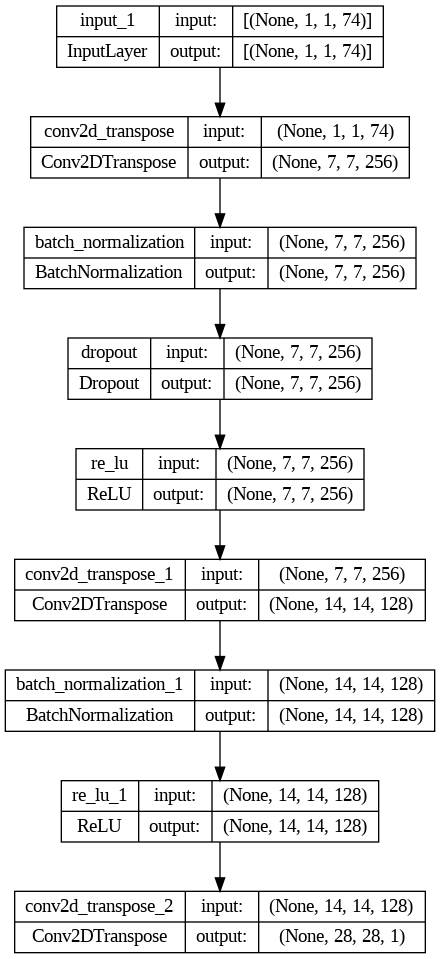

In [16]:
tf.keras.utils.plot_model(generator, show_shapes=True, show_layer_names=True)

In [14]:
def model_discriminator(input_shape=(28, 28, 1+n_classes)):
  initializer = tf.keras.initializers.RandomNormal(0., 0.02, seed=123)

  input=tf.keras.Input(shape=input_shape)
  x=tf.keras.layers.Conv2D(128, (4,4), strides=2, padding="same", kernel_initializer=initializer, use_bias=False)(input)
  x=tf.keras.layers.LeakyReLU(0.2)(x)

  x=tf.keras.layers.Conv2D(256, (4,4), strides=2, padding="same", kernel_initializer=initializer, use_bias=False)(x)
  x=tf.keras.layers.BatchNormalization()(x)
  x=tf.keras.layers.LeakyReLU(0.2)(x)

  x=tf.keras.layers.Conv2D(1, (7,7), strides=1, padding="valid", kernel_initializer=initializer)(x)
  x=tf.keras.layers.Flatten()(x)

  model=tf.keras.Model(inputs=input, outputs=x, name="discriminator")

  return model

In [15]:
discriminator=model_discriminator()
discriminator.summary()

Model: "discriminator"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 28, 28, 11)]      0         
                                                                 
 conv2d (Conv2D)             (None, 14, 14, 128)       22528     
                                                                 
 leaky_re_lu (LeakyReLU)     (None, 14, 14, 128)       0         
                                                                 
 conv2d_1 (Conv2D)           (None, 7, 7, 256)         524288    
                                                                 
 batch_normalization_2 (Bat  (None, 7, 7, 256)         1024      
 chNormalization)                                                
                                                                 
 leaky_re_lu_1 (LeakyReLU)   (None, 7, 7, 256)         0         
                                                     

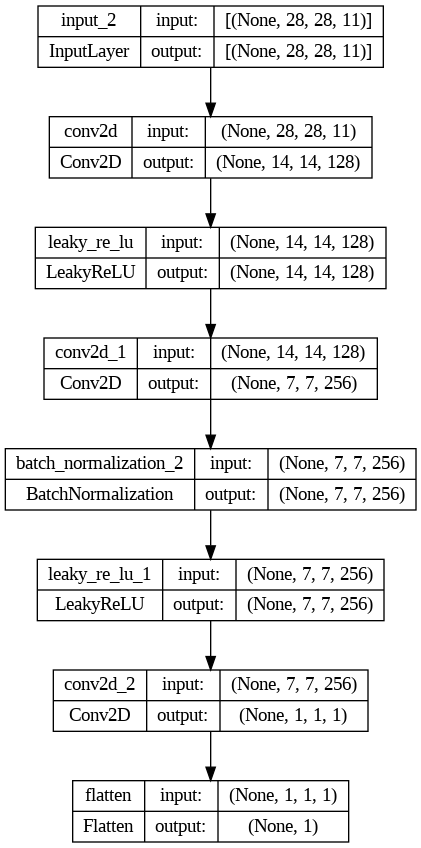

In [19]:
tf.keras.utils.plot_model(discriminator, show_shapes=True, show_layer_names=True)

**Training the Models**

In [16]:
gen_optimizer = tf.keras.optimizers.Adam(learning_rate=2e-4, beta_1=0.5)
disc_optimizer = tf.keras.optimizers.Adam(learning_rate=2e-4, beta_1=0.5)
loss_model = tf.keras.losses.BinaryCrossentropy(from_logits=True)

In [17]:
@tf.function
def train_step(real_images, labels_ohe):
  cur_batch_size = len(real_images)
  images_ohe = labels_ohe[:, None, None, :]
  images_ohe = tf.tile(images_ohe, [1, 28, 28, 1]) #shape=(cur_batch_size, 28, 28, n_classes)

  noise = tf.random.normal(shape=(cur_batch_size, z_dim))
  noise_labels = tf.concat([noise, labels_ohe], axis=-1)[:, None, None, :]

  with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
    fake_images=generator(noise_labels, training=True)

    real_out = discriminator(tf.concat([real_images, images_ohe], axis=-1), training=True)
    fake_out = discriminator(tf.concat([fake_images, images_ohe], axis=-1), training=True)

    # Generator Loss
    gen_loss = loss_model(tf.ones_like(fake_out), fake_out)

    # Discriminator Loss
    real_loss = loss_model(tf.ones_like(real_out), real_out)
    fake_loss = loss_model(tf.zeros_like(fake_out), fake_out)
    disc_loss = (fake_loss+real_loss) / 2

  gen_gradients = gen_tape.gradient(gen_loss, generator.trainable_variables)
  disc_gradients = disc_tape.gradient(disc_loss, discriminator.trainable_variables)

  gen_optimizer.apply_gradients(zip(gen_gradients, generator.trainable_variables))
  disc_optimizer.apply_gradients(zip(disc_gradients, discriminator.trainable_variables))

  return gen_loss, disc_loss

Generate random images to create the GIF

In [18]:
tf.random.set_seed(123) #for the reproducibility of noise tensors and labels_ohe
num_examples = 25
nrow = 5

noise_example = tf.random.normal((num_examples, z_dim))
labels_example = tf.random.uniform(shape=(num_examples, ), minval=0, maxval=10, dtype=tf.int32)
labels_ohe_example = tf.one_hot(labels_example, n_classes)
noise_labels_example = tf.concat([noise_example, labels_ohe_example], axis=-1)[:, None, None, :]
fake_images_example = generator(noise_labels_example, training=False)

In [19]:
labels_example

<tf.Tensor: shape=(25,), dtype=int32, numpy=
array([0, 0, 9, 3, 5, 4, 0, 3, 4, 2, 5, 3, 1, 7, 8, 1, 9, 7, 4, 6, 9, 6,
       0, 1, 9], dtype=int32)>

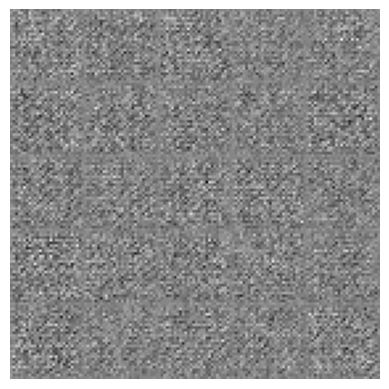

In [20]:
# Epoch 0 image
fake_images_example = make_grid(fake_images_example, num_examples, nrow)
fake_images_example = tf.cast((fake_images_example+1) * 127.5, tf.uint8) # Denormalization
plt.imshow(fake_images_example, cmap="gray")
plt.axis("off")
plt.savefig(os.path.join(directory_mnist, f"image{0:02d}.png"), transparent=True);

In [21]:
def train_gan(epochs=epochs, num_examples=num_examples, nrow=nrow):
  history={"gen_loss":[], "disc_loss":[]}

  for epoch in range(epochs):
    gen_loss_list, disc_loss_list = [], []

    with tqdm(train_dataset) as pbar:
      pbar.set_description(f"[Epoch: {epoch+1}/{epochs}]")
      for real_images, labels_ohe in pbar:
        gen_loss, disc_loss = train_step(real_images, labels_ohe)

        gen_loss_list.append(gen_loss.numpy())
        disc_loss_list.append(disc_loss.numpy())

        pbar.set_postfix({"gen_loss": gen_loss.numpy(), "disc_loss": disc_loss.numpy()})

    gen_loss_mean = np.mean(gen_loss_list)
    disc_loss_mean = np.mean(disc_loss_list)
    history["gen_loss"].append(gen_loss_mean)
    history["disc_loss"].append(disc_loss_mean)

    display.clear_output(wait=False)
    print(f"Epoch {epoch+1}, GeneratorLoss: {gen_loss_mean}, DiscriminatorLoss: {disc_loss_mean}")
    # Examples for training
    noise = tf.random.normal(shape=(len(real_images), z_dim))
    noise_labels = tf.concat([noise, labels_ohe], axis=-1)[:, None, None, :]
    fake_images = generator(noise_labels, training=False)

    #Examples for GIF
    fake_images_example = generator(noise_labels_example, training=False)

    show_and_save_images(real_images, fake_images, fake_images_example, epoch+1, num_examples, nrow)

  return history

Epoch 20, GeneratorLoss: 1.3196697235107422, DiscriminatorLoss: 0.49182915687561035


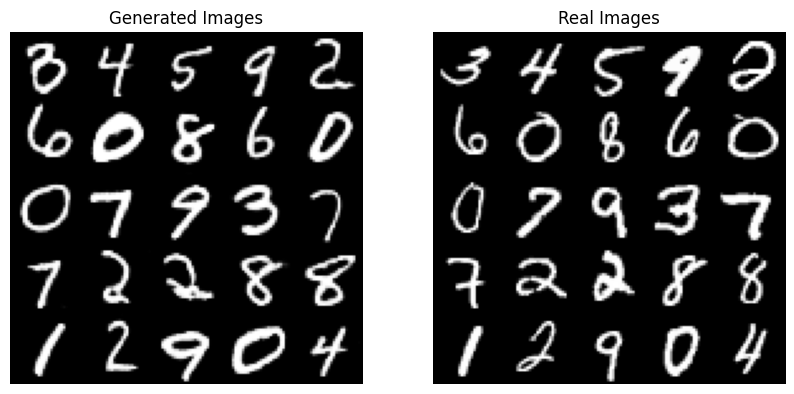

In [22]:
tf.random.set_seed(123)

history = train_gan()

In [2]:
def plot_metrics(history, renderer=None, epochs = epochs):
  gen_losses=history["gen_loss"]
  disc_losses=history["disc_loss"]
  list_epochs=np.arange(1, epochs+1)

  fig=go.Figure()
  fig.add_trace(go.Scatter(x=list_epochs, y=gen_losses, name="Generator Loss", line=dict(color="blue", width=2)))
  fig.add_trace(go.Scatter(x=list_epochs, y=disc_losses, name="Discriminator Loss", line=dict(color="#FF6600", width=2)))
  fig.update_xaxes(title_text="Epoch")
  fig.update_yaxes(title_text="Loss")
  fig.update_layout(title=f"<b>Evolution of Loss across Epochs</b>",
                    title_font=dict(size=20),
                    title_x=0.5,
                    height=500,
                    width=1200)

  fig.show(renderer)

In [24]:
# Interactive graphic
plot_metrics(history)

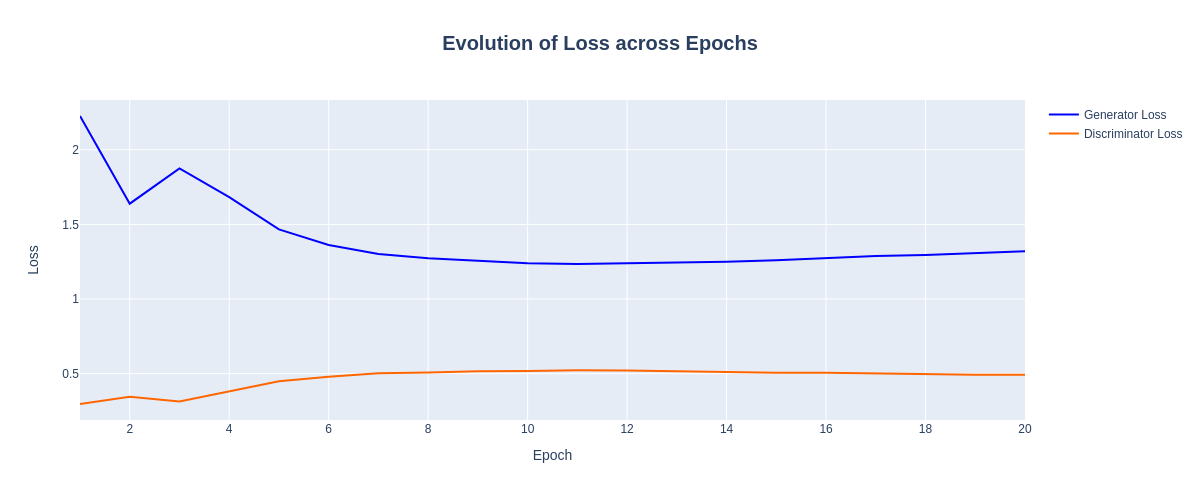

In [5]:
# Image for GitHub
plot_metrics(history, renderer="png")

In [29]:
# Save the generator

generator.save("/content/drive/MyDrive/models/generator_mnist_cond_gan.keras")

**Create a GIF from the generated images**

In [30]:
!pip install tensorflow_docs -q

import tensorflow_docs.vis.embed as embed

In [31]:
# Function to create gifs

def create_gif(gif_file, images_file, fps=1):
  with imageio.get_writer(gif_file, mode="I", loop=0, fps=fps) as writer:
    filenames = sorted(glob.glob(f"{images_file}/*.png"))
    for filename in filenames:
      image = imageio.imread(filename)
      writer.append_data(image)
    image = imageio.imread(filename)
    writer.append_data(image)


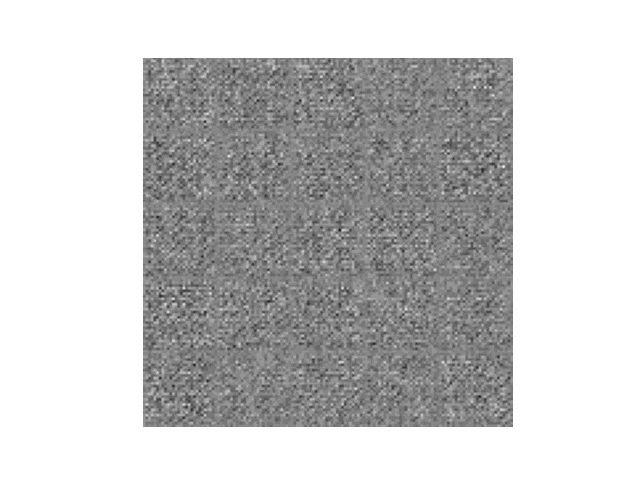

In [32]:
gif_file = os.path.join(directory_mnist, "mnist_cond_gan.gif")
create_gif(gif_file, directory_mnist, fps=2)
embed.embed_file(gif_file)

**Generated Examples**

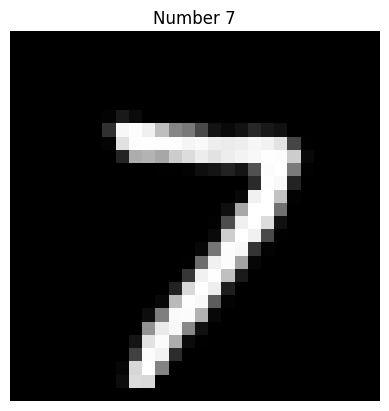

In [33]:
# Example
number = 7

noise = tf.random.normal(shape=(1, z_dim))
number_ohe = tf.one_hot(tf.constant([number]), n_classes)
noise_labels = tf.concat([noise, number_ohe], axis=-1)[:, None, None, :]
generated_example = generator(noise_labels).numpy().squeeze()
plt.imshow(generated_example, cmap="gray")
plt.title(f"Number {number}")
plt.axis("off");

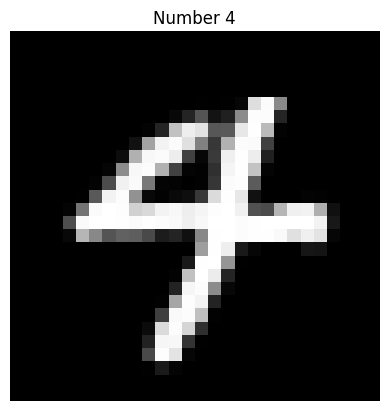

In [36]:
# Example
number = 4

noise = tf.random.normal(shape=(1, z_dim))
number_ohe = tf.one_hot(tf.constant([number]), n_classes)
noise_labels = tf.concat([noise, number_ohe], axis=-1)[:, None, None, :]
generated_example = generator(noise_labels).numpy().squeeze()
plt.imshow(generated_example, cmap="gray")
plt.title(f"Number {number}")
plt.axis("off");

**Class vector interpolation**

In [37]:
def show_images_interpolation(images, num_images=9, nrow=1, cmap="gray", title=""):
  fig, axes = plt.subplots(1, num_images, figsize=(num_images, 2))
  fig.suptitle(title)
  for i, ax in enumerate(axes):
    ax.imshow(images[i], cmap=cmap)
    ax.axis("off")

  plt.show()

In [38]:
def interpolate_class(first_number, second_number, n_interpolation, show=True):
  interpolation_noise=tf.tile(tf.random.normal(shape=(1, z_dim)), [n_interpolation, 1])

  first_label=tf.one_hot(tf.constant([first_number]), n_classes)
  second_label=tf.one_hot(tf.constant([second_number]), n_classes)

  percent_second_label=tf.cast(tf.linspace(0, 1, n_interpolation), dtype=tf.float32)[:, None]
  interpolation_labels=first_label*(1-percent_second_label) + second_label*percent_second_label

  noise_and_labels=tf.concat([interpolation_noise, interpolation_labels], axis=-1)
  fake_images=generator(noise_and_labels[:, None, None, :])
  fake_images = tf.cast((fake_images+1) * 127.5, tf.uint8)

  if show:
    show_images_interpolation(fake_images, n_interpolation, title=f"Class Intepolation; Numbers: {first_number}--->{second_number}")
  else:
    return fake_images

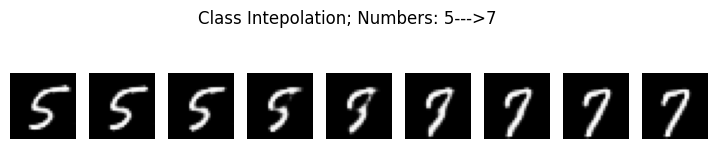

In [39]:
interpolate_class(first_number=5, second_number=7, n_interpolation=9)

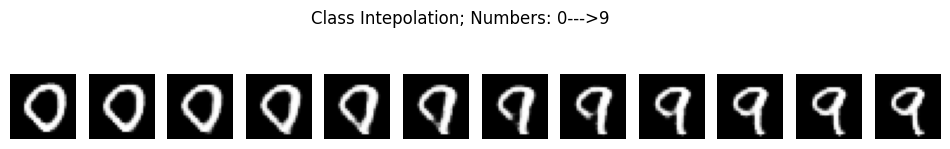

In [40]:
interpolate_class(first_number=0, second_number=9, n_interpolation=12)

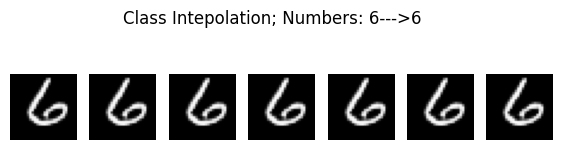

In [43]:
interpolate_class(first_number=6, second_number=6, n_interpolation=7)

**Noise vector interpolation**

In [44]:
def interpolate_noise(number, n_interpolation, show=True):
  first_noise=tf.random.normal(shape=(1, z_dim))
  second_noise=tf.random.normal(shape=(1, z_dim))

  interpolation_label=tf.tile(tf.one_hot(tf.constant([number]), n_classes), [n_interpolation, 1])
  percent_first_noise=tf.cast(tf.linspace(0, 1, n_interpolation), dtype=tf.float32)[:, None]
  interpolation_noise=first_noise*percent_first_noise + second_noise*(1 - percent_first_noise)

  noise_and_labels=tf.concat([interpolation_noise, interpolation_label], axis=-1)
  fake_images=generator(noise_and_labels[:, None, None, :])
  fake_images = tf.cast((fake_images+1) * 127.5, tf.uint8)

  if show:
    show_images_interpolation(fake_images, n_interpolation, title=f"Noise Intepolation; Number: {number}")
  else:
    return fake_images

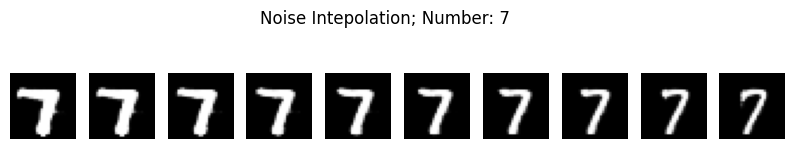

In [45]:
interpolate_noise(number=7, n_interpolation=10)

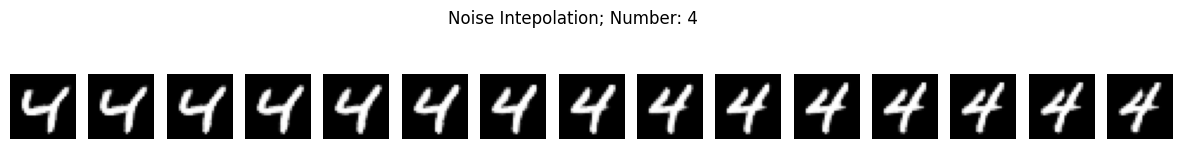

In [46]:
interpolate_noise(number=4, n_interpolation=15)

**Create a GIF of digits from the generated images with the interpolation class**

In [47]:
# Images directory
directory_mnist_inter = os.path.join(directory_images, "mnist_cond_gan_inter")
os.makedirs(directory_mnist_inter, exist_ok=True)

In [58]:
# Generate the images

c=0
for i in range(n_classes-1):
  images = interpolate_class(i, i+1, 10, show=False)
  for image in images.numpy().squeeze():
    plt.figure(figsize=(1, 1))
    plt.imshow(image, cmap="gray")
    plt.axis("off")
    plt.savefig(os.path.join(directory_mnist_inter, f"image_{c:03d}.png"), transparent=True)
    plt.close()
    c+=1


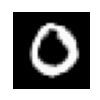

In [59]:
gif_file = os.path.join(directory_mnist_inter, "mnist_cond_gan_inter.gif")
create_gif(gif_file, directory_mnist_inter, fps=5)
embed.embed_file(gif_file)